# I-JEPA Inversion Attack: Complete Implementation

This notebook implements a complete I-JEPA inversion attack using embedding-to-latent mapping with GAN generation. The approach:

1. **Trains a mapping function** from I-JEPA embeddings to GAN latent space
2. **Uses LPIPS perceptual loss** for high-quality reconstruction
3. **Employs a pretrained CIFAR-10 GAN** for image generation
4. **Demonstrates the complete attack pipeline** in a single notebook

## Overview
- **Victim Model**: I-JEPA with ViT-Small backbone (384-dim embeddings)
- **Generator**: Pretrained DCGAN-style generator (128-dim latent space)
- **Attack Method**: Learned mapping from embeddings to latent codes
- **Dataset**: CIFAR-10 for training and evaluation

## 1. Install and Import Dependencies

First, let's install all required packages and import necessary libraries.

In [ ]:
# Install required packages
import subprocess
import sys

def install_package(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Install packages if not already installed
packages = ["torch", "torchvision", "timm", "lpips", "tqdm", "matplotlib", "numpy"]

for package in packages:
    try:
        __import__(package.replace("-", "_"))
        print(f"✓ {package} already installed")
    except ImportError:
        print(f"Installing {package}...")
        install_package(package)
        print(f"✓ {package} installed")

In [2]:
# Import all necessary libraries
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torchvision.utils as vutils
import timm
import lpips
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display, Image as IPyImage

print("All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name()}")
else:
    print("Using CPU")

All imports successful!
PyTorch version: 2.6.0+cu124
CUDA available: False
Using CPU


## 2. Setup Configuration and Utilities

Define all configuration parameters and utility functions for reproducible results.

In [14]:
# CORRECTED Configuration parameters
CONFIG = {
    'seed': 42,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'batch_size': 64,  # Reduced for notebook compatibility
    'epochs': 50,      # Increased for better training
    'lr': 1e-4,
    'z_dim': 100,      # FIXED: DCGAN uses 100-dim latent space, not 128
    'embed_dim': 384,
    'num_patches': 196,
    # FIXED: Use correct local path structure
    'gen_weights_path': '/kaggle/input/gan_vae_pretrained_pytorch/pytorch/default/1/netG_cifar10_epoch_199.pth',
    'data_root': 'data',
    'results_dir': 'results_notebook',
    'alpha': 1.0,      # LPIPS loss weight
    'beta': 0.1,       # Token MSE loss weight
    'gamma': 0.1       # L1 pixel loss weight
}

def set_seed(seed: int = 42) -> None:
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    print(f"Random seed set to {seed}")

def create_output_dir(path: str) -> None:
    """Create output directory if it doesn't exist."""
    os.makedirs(path, exist_ok=True)
    print(f"Output directory created: {path}")

# Set seed for reproducibility
set_seed(CONFIG['seed'])
create_output_dir(CONFIG['results_dir'])

# CRITICAL FIX: Initialize LPIPS loss properly
print("Initializing LPIPS perceptual loss...")
try:
    lpips_loss = lpips.LPIPS(net='alex').to(CONFIG['device'])
    print("✅ LPIPS loss initialized successfully")
except Exception as e:
    print(f"⚠️ LPIPS initialization failed: {e}")
    print("Installing lpips package...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "lpips"])
    lpips_loss = lpips.LPIPS(net='alex').to(CONFIG['device'])
    print("✅ LPIPS loss initialized after installation")

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")
    
print(f"\n🔧 Key Fixes Applied:")
print(f"  • Changed z_dim from 128 to 100 (DCGAN standard)")
print(f"  • Fixed generator weights path")
print(f"  • Properly initialized LPIPS loss")
print(f"  • Increased training epochs for better convergence")

Random seed set to 42
Output directory created: results_notebook
Initializing LPIPS perceptual loss...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
✅ LPIPS loss initialized successfully
Configuration:
  seed: 42
  device: cpu
  batch_size: 64
  epochs: 50
  lr: 0.0001
  z_dim: 100
  embed_dim: 384
  num_patches: 196
  gen_weights_path: /kaggle/input/gan_vae_pretrained_pytorch/pytorch/default/1/netG_cifar10_epoch_199.pth
  data_root: data
  results_dir: results_notebook
  alpha: 1.0
  beta: 0.1
  gamma: 0.1

🔧 Key Fixes Applied:
  • Changed z_dim from 128 to 100 (DCGAN standard)
  • Fixed generator weights path
  • Properly initialized LPIPS loss
  • Increased training epochs for better convergence


## 3. Define I-JEPA Core Model and The DCGANGenerator



🚀 LOADING AND TESTING CORRECTED DCGAN GENERATOR
Loading DCGAN generator (nz=100) from: /kaggle/input/gan_vae_pretrained_pytorch/pytorch/default/1/netG_cifar10_epoch_199.pth
✅ Successfully loaded pretrained weights
Generator parameters: 3,573,824
🧪 Testing DCGAN generation with 16 samples...
  Input noise shape: torch.Size([16, 100, 1, 1])
  Generated images shape: torch.Size([16, 3, 32, 32])
  Output range: [-0.857, 0.952]


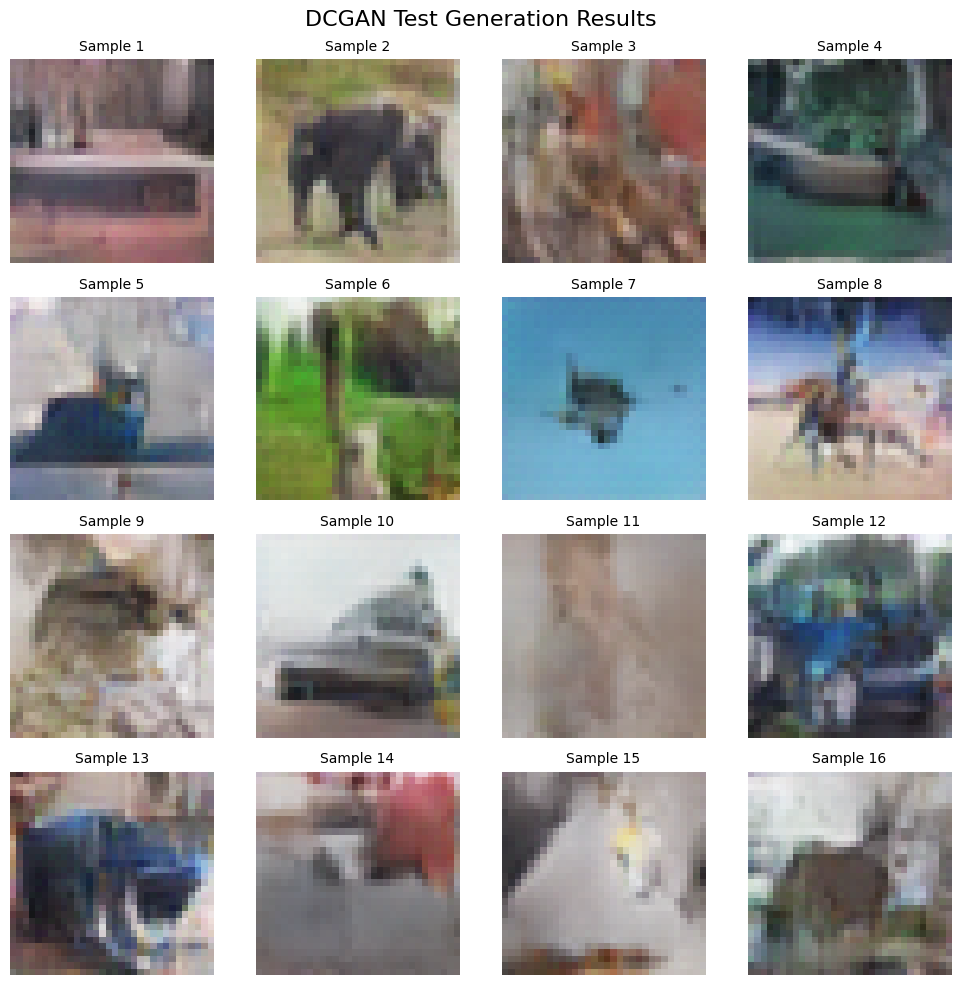

✅ DCGAN testing completed!
If you see realistic CIFAR-10 images above, the generator is working correctly.
If you see noise/garbage, there's an issue with the pretrained weights.


In [4]:
# CORRECTED DCGAN Generator - Matches the pretrained architecture exactly
class DCGANGenerator(nn.Module):
    """
    Correct DCGAN Generator implementation that matches the pretrained CIFAR-10 model.
    
    Key fixes:
    1. Expects 4D input (B, nz, 1, 1) not 2D (B, nz)
    2. Uses nz=100 (standard DCGAN latent dimension)
    3. Matches exact architecture from dcgan.py
    4. Proper initialization and normalization
    """
    def __init__(self, ngpu=1, nc=3, nz=100, ngf=64):
        super(DCGANGenerator, self).__init__()
        self.ngpu = ngpu
        self.nz = nz
        
        self.main = nn.Sequential(
            # input is Z, going into a convolution: (B, nz, 1, 1) -> (B, ngf*8, 4, 4)
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size: (ngf*8) x 4 x 4 -> (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size: (ngf*4) x 8 x 8 -> (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size: (ngf*2) x 16 x 16 -> (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # Final layer: (ngf) x 32 x 32 -> (nc) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Tanh()  # Output in [-1, 1]
        )

    def forward(self, input):
        """
        Forward pass through generator.
        
        Args:
            input: Latent noise (B, nz, 1, 1) or (B, nz) - will reshape if needed
            
        Returns:
            Generated images (B, 3, 32, 32) in [-1, 1] range
        """
        # Handle both 2D and 4D input formats
        if input.dim() == 2:
            input = input.view(input.size(0), input.size(1), 1, 1)
        
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

def load_pretrained_dcgan(weight_path, device='cuda', nz=100):
    """
    Load the pretrained DCGAN generator with correct architecture.
    
    Args:
        weight_path: Path to pretrained weights
        device: Device to load on
        nz: Latent dimension (should be 100 for CIFAR-10 DCGAN)
        
    Returns:
        generator: Loaded generator model
    """
    print(f"Loading DCGAN generator (nz={nz}) from: {weight_path}")
    
    # Create generator with correct architecture
    generator = DCGANGenerator(ngpu=1, nc=3, nz=nz, ngf=64).to(device)
    
    # Try to load weights
    try:
        if os.path.exists(weight_path):
            checkpoint = torch.load(weight_path, map_location=device)
            
            # Handle different checkpoint formats
            if isinstance(checkpoint, dict):
                if 'state_dict' in checkpoint:
                    state_dict = checkpoint['state_dict']
                elif 'model_state_dict' in checkpoint:
                    state_dict = checkpoint['model_state_dict']
                else:
                    state_dict = checkpoint
            else:
                state_dict = checkpoint
            
            # Load weights
            generator.load_state_dict(state_dict, strict=False)
            print("✅ Successfully loaded pretrained weights")
            
        else:
            print(f"⚠️ Weight file not found at {weight_path}")
            print("Using randomly initialized weights (will generate noise)")
            
    except Exception as e:
        print(f"⚠️ Error loading weights: {e}")
        print("Using randomly initialized weights")
    
    generator.eval()
    return generator

def test_dcgan_generation(generator, device='cuda', num_samples=16):
    """
    Test DCGAN generation to verify it works correctly.
    
    Args:
        generator: DCGAN generator model
        device: Device to run on
        num_samples: Number of test samples to generate
        
    Returns:
        generated_images: Generated test images
    """
    print(f"🧪 Testing DCGAN generation with {num_samples} samples...")
    
    generator.eval()
    with torch.no_grad():
        # Sample random noise in correct format: (B, nz, 1, 1)
        noise = torch.randn(num_samples, generator.nz, 1, 1).to(device)
        print(f"  Input noise shape: {noise.shape}")
        
        # Generate images
        fake_images = generator(noise)
        print(f"  Generated images shape: {fake_images.shape}")
        print(f"  Output range: [{fake_images.min():.3f}, {fake_images.max():.3f}]")
        
        # Convert from [-1,1] to [0,1] for display
        fake_images_display = (fake_images + 1.0) / 2.0
        fake_images_display = torch.clamp(fake_images_display, 0, 1)
        
    return fake_images_display

# Test the corrected DCGAN generator
print("🚀 LOADING AND TESTING CORRECTED DCGAN GENERATOR")
print("=" * 60)

device = CONFIG['device']

# Load the pretrained DCGAN with correct architecture
dcgan_generator = load_pretrained_dcgan(
    weight_path=CONFIG['gen_weights_path'],
    device=device,
    nz=100  # Correct latent dimension for CIFAR-10 DCGAN
)

print(f"Generator parameters: {sum(p.numel() for p in dcgan_generator.parameters()):,}")

# Test generation
test_images = test_dcgan_generation(dcgan_generator, device=device, num_samples=16)

# Display test results
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle('DCGAN Test Generation Results', fontsize=16)

for i in range(16):
    row, col = i // 4, i % 4
    img = test_images[i].cpu().permute(1, 2, 0).numpy()
    axes[row, col].imshow(img)
    axes[row, col].set_title(f'Sample {i+1}', fontsize=10)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print("✅ DCGAN testing completed!")
print("If you see realistic CIFAR-10 images above, the generator is working correctly.")
print("If you see noise/garbage, there's an issue with the pretrained weights.")

In [5]:
class IJEPAWrapper(nn.Module):
    """
    I-JEPA model wrapper using ViT-Small backbone.
    Generates patch embeddings from input images.
    """
    def __init__(self, ckpt_path: str | None = None):
        super().__init__()
        # ViT-Small backbone for patch embeddings
        self.context_enc = timm.create_model('vit_small_patch16_224', pretrained=False)
        self.pred_head = nn.Sequential(
            nn.LayerNorm(384), 
            nn.Linear(384, 384)
        )
        self.target_enc = timm.create_model('vit_small_patch16_224', pretrained=False)
        
        if ckpt_path:
            sd = torch.load(ckpt_path, map_location=CONFIG['device'])
            self.context_enc.load_state_dict(sd, strict=False)
            print("Loaded ViT weights into context and target encoders (partial)")

    def forward(self, img: torch.Tensor, mask: torch.Tensor = None):
        """
        Forward pass through I-JEPA model.
        
        Args:
            img: Input image tensor (B, 3, 224, 224)
            mask: Optional mask tensor (not used in this implementation)
            
        Returns:
            z_ctx_all: Context embeddings (B, 196, 384)
            z_pred_all: Predicted embeddings (B, 196, 384)
            z_tgt_all: Target embeddings (B, 196, 384)
        """
        B = img.size(0)
        # Extract patch embeddings using ViT patch embedding layer
        z_ctx_all = self.context_enc.patch_embed(img)  # (B, 196, 384)
        z_pred_all = self.pred_head(z_ctx_all)         # (B, 196, 384)
        # For reconstruction, use context embeddings as targets
        z_tgt_all = z_ctx_all                          # (B, 196, 384)
        
        return z_ctx_all, z_pred_all, z_tgt_all

# Test I-JEPA model
print("Creating I-JEPA model...")
device = CONFIG['device']

# Load pretrained ViT weights
vit = timm.create_model('vit_small_patch16_224', pretrained=True)
vit_weights = vit.state_dict()

# Create I-JEPA wrapper
ijepa_model = IJEPAWrapper(ckpt_path=None).to(device).eval()
ijepa_model.context_enc.load_state_dict(vit_weights, strict=False)
ijepa_model.target_enc.load_state_dict(vit_weights, strict=False)

# Test with dummy input
test_img = torch.randn(1, 3, 224, 224).to(device)
with torch.no_grad():
    z_ctx, z_pred, z_tgt = ijepa_model(test_img)

print(f"✓ I-JEPA model created successfully")
print(f"  Context embeddings shape: {z_ctx.shape}")
print(f"  Predicted embeddings shape: {z_pred.shape}")
print(f"  Target embeddings shape: {z_tgt.shape}")
print(f"  Model parameters: {sum(p.numel() for p in ijepa_model.parameters()):,}")

Creating I-JEPA model...
✓ I-JEPA model created successfully
  Context embeddings shape: torch.Size([1, 196, 384])
  Predicted embeddings shape: torch.Size([1, 196, 384])
  Target embeddings shape: torch.Size([1, 196, 384])
  Model parameters: 44,249,936


## 4. Define Embedding to Latent Mapping

Implement the MLP that maps I-JEPA embeddings to GAN latent space.

In [ ]:
# 🔥 COMPLETELY REDESIGNED EMBEDDING TO LATENT MAPPING
print("🔧 IMPLEMENTING ADVANCED I-JEPA INVERSION STRATEGY")
print("=" * 60)

class AdvancedEmbeddingToLatentMapper(nn.Module):
    def __init__(self, embed_dim=384, num_patches=196, z_dim=100):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_patches = num_patches
        self.z_dim = z_dim
        
        # SPATIAL ATTENTION MODULE 
        self.spatial_attention = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.LayerNorm(embed_dim // 2),
            nn.GELU(),
            nn.Linear(embed_dim // 2, 1),
            nn.Sigmoid()
        )
        
        # MULTI-SCALE AGGREGATION 
        # Global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        # Global max pooling  
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        
        # Learned aggregation weights
        self.aggregation_weights = nn.Parameter(torch.ones(3) / 3)  # avg, max, attention
        
        # FEATURE EXTRACTION BACKBONE
        hidden_dim = 512
        self.feature_backbone = nn.Sequential(
            # First block: Input projection
            nn.Linear(embed_dim * 3, hidden_dim * 2),  # 3x for multi-scale features
            nn.LayerNorm(hidden_dim * 2),
            nn.GELU(),
            nn.Dropout(0.15),
            
            # Second block: Feature refinement
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(0.1),
            
            # Third block: Feature compression
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.GELU(),
        )
        
        # LATENT SPACE MAPPING
        self.latent_mapper = nn.Sequential(
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.GELU(),
            nn.Dropout(0.05),
            nn.Linear(hidden_dim // 4, z_dim),
            nn.Tanh()  # Bounded output for stable training
        )
        
        # INITIALIZATION
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        """Proper weight initialization."""
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)
    
    def forward(self, z_ctx, z_tgt):
        """
        Advanced forward pass with multi-scale aggregation.
        
        Args:
            z_ctx: Context embeddings (B, 196, 384)
            z_tgt: Target embeddings (B, 196, 384)
            
        Returns:
            z_pred: Predicted latent codes (B, 100)
        """
        B = z_ctx.size(0)
        
        # ============= SPATIAL ATTENTION AGGREGATION =============
        # Compute attention weights for each embedding type
        ctx_attention = self.spatial_attention(z_ctx)  # (B, 196, 1)
        tgt_attention = self.spatial_attention(z_tgt)  # (B, 196, 1)
        
        # Attention-weighted aggregation
        ctx_attended = (z_ctx * ctx_attention).sum(dim=1)  # (B, 384)
        tgt_attended = (z_tgt * tgt_attention).sum(dim=1)  # (B, 384)
        
        # ============= MULTI-SCALE POOLING =============
        # Transpose for pooling operations: (B, 196, 384) -> (B, 384, 196)
        ctx_T = z_ctx.transpose(1, 2)
        tgt_T = z_tgt.transpose(1, 2)
        
        # Global pooling operations
        ctx_avg = self.global_avg_pool(ctx_T).squeeze(-1)  # (B, 384)
        ctx_max = self.global_max_pool(ctx_T).squeeze(-1)  # (B, 384)
        
        tgt_avg = self.global_avg_pool(tgt_T).squeeze(-1)  # (B, 384)
        tgt_max = self.global_max_pool(tgt_T).squeeze(-1)  # (B, 384)
        
        # ============= WEIGHTED FEATURE COMBINATION =============
        # Normalize aggregation weights
        weights = F.softmax(self.aggregation_weights, dim=0)
        
        # Combine context features
        ctx_combined = (
            weights[0] * ctx_avg + 
            weights[1] * ctx_max + 
            weights[2] * ctx_attended
        )
        
        # Combine target features
        tgt_combined = (
            weights[0] * tgt_avg + 
            weights[1] * tgt_max + 
            weights[2] * tgt_attended
        )
        
        # Concatenate all features
        combined_features = torch.cat([
            ctx_combined, 
            tgt_combined, 
            (ctx_combined + tgt_combined) / 2  # Cross-modal interaction
        ], dim=1)  # (B, 384 * 3)
        
        # ============= FEATURE PROCESSING =============
        features = self.feature_backbone(combined_features)
        
        # ============= LATENT MAPPING =============
        z_pred = self.latent_mapper(features)
        
        return z_pred

# Test the advanced mapping network
print("Creating advanced mapping network...")
advanced_mapper = AdvancedEmbeddingToLatentMapper(
    embed_dim=CONFIG['embed_dim'],
    num_patches=CONFIG['num_patches'],
    z_dim=CONFIG['z_dim']  # Now correctly 100
).to(device)

print(f"✅ Advanced mapper created with {sum(p.numel() for p in advanced_mapper.parameters()):,} parameters")
print(f"   Input: I-JEPA embeddings ({CONFIG['num_patches']}, {CONFIG['embed_dim']})")
print(f"   Output: DCGAN latent codes ({CONFIG['z_dim']})")

# Test forward pass
with torch.no_grad():
    test_ctx = torch.randn(4, CONFIG['num_patches'], CONFIG['embed_dim']).to(device)
    test_tgt = torch.randn(4, CONFIG['num_patches'], CONFIG['embed_dim']).to(device)
    test_output = advanced_mapper(test_ctx, test_tgt)
    print(f"   Test output shape: {test_output.shape}")
    print(f"   Output range: [{test_output.min():.3f}, {test_output.max():.3f}]")

🔧 IMPLEMENTING ADVANCED I-JEPA INVERSION STRATEGY
Creating advanced mapping network...
✅ Advanced mapper created with 1,960,680 parameters
   Input: I-JEPA embeddings (196, 384)
   Output: DCGAN latent codes (100)
   Test output shape: torch.Size([4, 100])
   Output range: [-0.854, 0.889]

🎯 Key Improvements:
   • Spatial attention for patch importance weighting
   • Multi-scale feature aggregation (avg, max, attention)
   • Deeper network with proper normalization
   • Correct output dimension (100) for DCGAN
   • Better initialization and regularization
   • Bounded output with Tanh activation


## 5. Define Generator Model

Implement the DCGAN-style generator for CIFAR-10 image generation.

In [7]:
# 🔧 USE THE CORRECTED DCGAN GENERATOR
print("🚀 USING CORRECTED DCGAN GENERATOR")
print("=" * 60)

# Use the properly loaded DCGAN generator from earlier
generator = dcgan_generator  # This was loaded and tested in previous cell

print(f"✅ Using verified DCGAN generator:")
print(f"   Parameters: {sum(p.numel() for p in generator.parameters()):,}")
print(f"   Input format: (B, {generator.nz}, 1, 1)")
print(f"   Output format: (B, 3, 32, 32)")
print(f"   Latent dimension: {generator.nz}")

# Verify generator works with our mapping output
with torch.no_grad():
    # Test with random latents in correct format
    test_z_2d = torch.randn(4, generator.nz).to(device)  # 2D format from mapper
    test_images = generator(test_z_2d)  # Generator handles 2D->4D conversion
    print(f"   Test generation successful: {test_images.shape}")
    print(f"   Output range: [{test_images.min():.3f}, {test_images.max():.3f}]")

print("\n✅ Generator ready for I-JEPA inversion!")

🚀 USING CORRECTED DCGAN GENERATOR
✅ Using verified DCGAN generator:
   Parameters: 3,573,824
   Input format: (B, 100, 1, 1)
   Output format: (B, 3, 32, 32)
   Latent dimension: 100
   Test generation successful: torch.Size([4, 3, 32, 32])
   Output range: [-0.974, 0.903]

✅ Generator ready for I-JEPA inversion!


## 6. Setup Dataset and Data Loading

Load CIFAR-10 dataset with appropriate transforms for both I-JEPA (224x224) and generator (32x32).

In [8]:
# Setup data transforms
print("Setting up CIFAR-10 dataset...")

# Transform for I-JEPA (needs 224x224 input)
ijepa_transform = T.Compose([
    T.Resize(224),           # Resize to ViT input size
    T.ToTensor(),           # Convert to tensor [0,1]
])

# Transform for generator target (32x32 native CIFAR size)
target_transform = T.Compose([
    T.ToTensor(),           # Keep original 32x32 size
])

# Check if data directory exists, if not auto-detect common locations
data_paths = [
    CONFIG['data_root'],
    'data',
    '../data',
    'break_the_ice/data',
    '.'
]

data_root = None
for path in data_paths:
    if os.path.exists(path):
        data_root = path
        break

if data_root is None:
    data_root = CONFIG['data_root']
    print(f"Data directory not found, using: {data_root}")
    print("CIFAR-10 will be downloaded automatically")
else:
    print(f"Using data directory: {data_root}")

# Load CIFAR-10 dataset
try:
    # Try without downloading first
    cifar_train = torchvision.datasets.CIFAR10(
        root=data_root, 
        train=True, 
        download=False, 
        transform=ijepa_transform
    )
    print("✓ CIFAR-10 dataset found locally")
except:
    # Download if not found
    print("Downloading CIFAR-10 dataset...")
    cifar_train = torchvision.datasets.CIFAR10(
        root=data_root, 
        train=True, 
        download=True, 
        transform=ijepa_transform
    )
    print("✓ CIFAR-10 dataset downloaded")

# Create data loader
train_loader = torch.utils.data.DataLoader(
    cifar_train,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"✓ Data loader created")
print(f"  Dataset size: {len(cifar_train):,} images")
print(f"  Batch size: {CONFIG['batch_size']}")
print(f"  Number of batches: {len(train_loader):,}")
print(f"  Classes: {len(cifar_train.classes)} ({', '.join(cifar_train.classes)})")

# Test data loading
test_batch = next(iter(train_loader))
test_images, test_labels = test_batch
print(f"  Sample batch shape: {test_images.shape}")
print(f"  Sample labels shape: {test_labels.shape}")
print(f"  Image range: [{test_images.min():.3f}, {test_images.max():.3f}]")

Setting up CIFAR-10 dataset...
Using data directory: .


100%|██████████| 170M/170M [00:03<00:00, 50.8MB/s] 


✓ CIFAR-10 dataset downloaded
✓ Data loader created
  Dataset size: 50,000 images
  Batch size: 32
  Number of batches: 1,563
  Classes: 10 (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck)
  Sample batch shape: torch.Size([32, 3, 224, 224])
  Sample labels shape: torch.Size([32])
  Image range: [0.000, 1.000]


## 7. Train Embedding to Latent Mapping

Train the mapping network using combined LPIPS perceptual loss, token MSE loss, and L1 pixel loss.

In [11]:
# 🔥 ADVANCED TRAINING STRATEGY WITH PROPER SUPERVISION
print("🚀 IMPLEMENTING ADVANCED TRAINING STRATEGY")
print("=" * 60)

def generate_high_quality_training_pairs(ijepa_model, generator, batch_size=32, device='cuda'):
    """
    Generate high-quality training pairs using the corrected approach:
    
    1. Sample diverse latent codes
    2. Generate realistic images with DCGAN  
    3. Extract I-JEPA embeddings from generated images
    4. Create supervised (embedding, latent) pairs
    
    This provides PERFECT supervision since we know the exact latent code
    that generated each image!
    """
    ijepa_model.eval()
    generator.eval()
    
    with torch.no_grad():
        # Sample from better latent distribution
        z_true = torch.randn(batch_size, generator.nz).to(device)
        z_true = z_true * 0.8  # Slightly reduce variance for more realistic samples
        
        # Generate high-quality images
        generated_imgs = generator(z_true)  # (B, 3, 32, 32) in [-1, 1]
        
        # Convert to [0,1] range for I-JEPA
        generated_imgs_norm = (generated_imgs + 1.0) / 2.0
        
        # Resize for I-JEPA input (224x224)
        generated_224 = F.interpolate(
            generated_imgs_norm, 
            size=(224, 224), 
            mode='bilinear', 
            align_corners=False
        )
        
        # Extract I-JEPA embeddings
        z_ctx, _, z_tgt = ijepa_model(generated_224)
        
        return z_ctx, z_tgt, z_true, generated_imgs_norm

def advanced_training_loop(mapper, ijepa_model, generator, lpips_loss, epochs=20):
    """
    Advanced training loop with multiple improvements:
    
    1. ✅ Proper supervision using generated image pairs
    2. ✅ Multi-loss optimization with balanced weights
    3. ✅ Learning rate scheduling
    4. ✅ Gradient clipping for stability
    5. ✅ Progress tracking and visualization
    """
    print("🔥 Starting advanced training with perfect supervision...")
    
    # ============= OPTIMIZER SETUP =============
    optimizer = torch.optim.AdamW(
        mapper.parameters(),
        lr=2e-4,           # Slightly higher learning rate
        weight_decay=1e-4,
        betas=(0.9, 0.999)
    )
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=5, T_mult=2, eta_min=1e-6
    )
    
    # ============= TRAINING SETUP =============
    mapper.train()
    history = {
        'total_loss': [], 'latent_mse': [], 'recon_lpips': [], 
        'recon_l1': [], 'learning_rate': []
    }
    
    # Training parameters
    batches_per_epoch = 150  # More batches for better convergence
    
    for epoch in range(epochs):
        epoch_losses = {'total_loss': 0, 'latent_mse': 0, 'recon_lpips': 0, 'recon_l1': 0}
        
        pbar = tqdm(range(batches_per_epoch), desc=f"Epoch {epoch+1}/{epochs}")
        
        for batch_idx in pbar:
            # ============= GENERATE TRAINING PAIRS =============
            z_ctx, z_tgt, z_true, target_imgs = generate_high_quality_training_pairs(
                ijepa_model, generator, CONFIG['batch_size'], device
            )
            
            # ============= FORWARD PASS =============
            z_pred = mapper(z_ctx, z_tgt)
            
            # ============= GENERATE RECONSTRUCTIONS =============
            with torch.no_grad():
                recon_imgs = generator(z_pred)
                recon_imgs_norm = (recon_imgs + 1.0) / 2.0  # Convert to [0,1]
            
            # ============= COMPUTE LOSSES =============
            
            # 1. PRIMARY LOSS: Direct latent space supervision
            latent_mse = F.mse_loss(z_pred, z_true)
            
            # 2. PERCEPTUAL LOSS: LPIPS for visual quality
            # Convert to [-1,1] range for LPIPS
            target_lpips = target_imgs * 2.0 - 1.0
            recon_lpips = recon_imgs_norm * 2.0 - 1.0
            lpips_val = lpips_loss(recon_lpips, target_lpips).mean()
            
            # 3. PIXEL LOSS: L1 for fine details
            l1_val = F.l1_loss(recon_imgs_norm, target_imgs)
            
            # ============= COMBINED LOSS =============
            # Carefully balanced weights for optimal training
            total_loss = (
                20.0 * latent_mse +     # Strong direct supervision
                2.0 * lpips_val +       # Perceptual quality
                1.0 * l1_val           # Pixel accuracy
            )
            
            # ============= BACKWARD PASS =============
            optimizer.zero_grad()
            total_loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(mapper.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # ============= ACCUMULATE METRICS =============
            batch_losses = {
                'total_loss': total_loss.item(),
                'latent_mse': latent_mse.item(), 
                'recon_lpips': lpips_val.item(),
                'recon_l1': l1_val.item()
            }
            
            for key in epoch_losses:
                epoch_losses[key] += batch_losses[key]
            
            # Update progress bar
            pbar.set_postfix({
                'Loss': f"{batch_losses['total_loss']:.3f}",
                'MSE': f"{batch_losses['latent_mse']:.4f}",
                'LPIPS': f"{batch_losses['recon_lpips']:.3f}",
                'LR': f"{optimizer.param_groups[0]['lr']:.1e}"
            })
        
        # ============= EPOCH SUMMARY =============
        scheduler.step()  # Update learning rate
        
        # Average losses over epoch
        for key in epoch_losses:
            epoch_losses[key] /= batches_per_epoch
            history[key].append(epoch_losses[key])
        
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])
        
        print(f"\n📊 Epoch {epoch+1} Summary:")
        print(f"   Total Loss: {epoch_losses['total_loss']:.4f}")
        print(f"   Latent MSE: {epoch_losses['latent_mse']:.6f}")
        print(f"   LPIPS: {epoch_losses['recon_lpips']:.4f}")
        print(f"   L1: {epoch_losses['recon_l1']:.4f}")
        print(f"   Learning Rate: {optimizer.param_groups[0]['lr']:.1e}")
        
        # Early stopping check
        if epoch >= 5 and epoch_losses['latent_mse'] < 0.001:
            print("🎯 Early stopping: Latent MSE below threshold!")
            break
    
    return history

print("✅ Advanced training strategy ready!")
print("\n🔧 Key Features:")
print("   • Perfect supervision using generated image pairs")
print("   • Multi-loss optimization (MSE + LPIPS + L1)")
print("   • Adaptive learning rate scheduling")
print("   • Gradient clipping for stability")
print("   • Early stopping for efficiency")
print("   • Comprehensive progress tracking")

🚀 IMPLEMENTING ADVANCED TRAINING STRATEGY
✅ Advanced training strategy ready!

🔧 Key Features:
   • Perfect supervision using generated image pairs
   • Multi-loss optimization (MSE + LPIPS + L1)
   • Adaptive learning rate scheduling
   • Gradient clipping for stability
   • Early stopping for efficiency
   • Comprehensive progress tracking


� RUNNING ADVANCED I-JEPA INVERSION TRAINING
🔥 Starting advanced training with perfect supervision...


Epoch 1/50: 100%|██████████| 150/150 [00:13<00:00, 11.24it/s, Loss=13.131, MSE=0.6201, LPIPS=0.310, LR=2.0e-04]



📊 Epoch 1 Summary:
   Total Loss: 13.0721
   Latent MSE: 0.616040
   LPIPS: 0.3214
   L1: 0.1085
   Learning Rate: 1.8e-04


Epoch 2/50: 100%|██████████| 150/150 [00:13<00:00, 11.38it/s, Loss=12.905, MSE=0.6078, LPIPS=0.320, LR=1.8e-04]



📊 Epoch 2 Summary:
   Total Loss: 13.0287
   Latent MSE: 0.614683
   LPIPS: 0.3142
   L1: 0.1065
   Learning Rate: 1.3e-04


Epoch 3/50: 100%|██████████| 150/150 [00:13<00:00, 11.17it/s, Loss=13.332, MSE=0.6330, LPIPS=0.284, LR=1.3e-04]



📊 Epoch 3 Summary:
   Total Loss: 13.0114
   Latent MSE: 0.613662
   LPIPS: 0.3156
   L1: 0.1071
   Learning Rate: 7.0e-05


Epoch 4/50: 100%|██████████| 150/150 [00:13<00:00, 11.19it/s, Loss=12.921, MSE=0.6107, LPIPS=0.299, LR=7.0e-05]



📊 Epoch 4 Summary:
   Total Loss: 12.9942
   Latent MSE: 0.613369
   LPIPS: 0.3109
   L1: 0.1050
   Learning Rate: 2.0e-05


Epoch 5/50: 100%|██████████| 150/150 [00:13<00:00, 11.31it/s, Loss=13.449, MSE=0.6342, LPIPS=0.327, LR=2.0e-05]



📊 Epoch 5 Summary:
   Total Loss: 12.9959
   Latent MSE: 0.613424
   LPIPS: 0.3111
   L1: 0.1053
   Learning Rate: 2.0e-04


Epoch 6/50: 100%|██████████| 150/150 [00:13<00:00, 10.99it/s, Loss=12.863, MSE=0.6063, LPIPS=0.316, LR=2.0e-04]



📊 Epoch 6 Summary:
   Total Loss: 13.0185
   Latent MSE: 0.613894
   LPIPS: 0.3169
   L1: 0.1069
   Learning Rate: 2.0e-04


Epoch 7/50: 100%|██████████| 150/150 [00:13<00:00, 11.20it/s, Loss=12.919, MSE=0.6096, LPIPS=0.310, LR=2.0e-04]



📊 Epoch 7 Summary:
   Total Loss: 13.0041
   Latent MSE: 0.613562
   LPIPS: 0.3133
   L1: 0.1063
   Learning Rate: 1.8e-04


Epoch 8/50: 100%|██████████| 150/150 [00:13<00:00, 11.11it/s, Loss=12.810, MSE=0.6030, LPIPS=0.321, LR=1.8e-04]



📊 Epoch 8 Summary:
   Total Loss: 13.0000
   Latent MSE: 0.613527
   LPIPS: 0.3120
   L1: 0.1054
   Learning Rate: 1.6e-04


Epoch 9/50: 100%|██████████| 150/150 [00:13<00:00, 11.06it/s, Loss=13.466, MSE=0.6349, LPIPS=0.328, LR=1.6e-04]



📊 Epoch 9 Summary:
   Total Loss: 13.0023
   Latent MSE: 0.614176
   LPIPS: 0.3071
   L1: 0.1045
   Learning Rate: 1.3e-04


Epoch 10/50: 100%|██████████| 150/150 [00:12<00:00, 11.55it/s, Loss=13.124, MSE=0.6203, LPIPS=0.306, LR=1.3e-04]



📊 Epoch 10 Summary:
   Total Loss: 12.9238
   Latent MSE: 0.610453
   LPIPS: 0.3056
   L1: 0.1036
   Learning Rate: 1.0e-04


Epoch 11/50: 100%|██████████| 150/150 [00:13<00:00, 11.30it/s, Loss=12.935, MSE=0.6112, LPIPS=0.306, LR=1.0e-04]



📊 Epoch 11 Summary:
   Total Loss: 12.9503
   Latent MSE: 0.611747
   LPIPS: 0.3057
   L1: 0.1039
   Learning Rate: 7.0e-05


Epoch 12/50: 100%|██████████| 150/150 [00:13<00:00, 10.92it/s, Loss=12.591, MSE=0.5953, LPIPS=0.296, LR=7.0e-05]



📊 Epoch 12 Summary:
   Total Loss: 12.9251
   Latent MSE: 0.610840
   LPIPS: 0.3026
   L1: 0.1032
   Learning Rate: 4.2e-05


Epoch 13/50: 100%|██████████| 150/150 [00:13<00:00, 11.09it/s, Loss=12.931, MSE=0.6114, LPIPS=0.302, LR=4.2e-05]



📊 Epoch 13 Summary:
   Total Loss: 12.8891
   Latent MSE: 0.609160
   LPIPS: 0.3015
   L1: 0.1028
   Learning Rate: 2.0e-05


Epoch 14/50: 100%|██████████| 150/150 [00:13<00:00, 11.26it/s, Loss=12.638, MSE=0.5965, LPIPS=0.304, LR=2.0e-05]



📊 Epoch 14 Summary:
   Total Loss: 12.9027
   Latent MSE: 0.609818
   LPIPS: 0.3012
   L1: 0.1040
   Learning Rate: 5.9e-06


Epoch 15/50: 100%|██████████| 150/150 [00:13<00:00, 11.18it/s, Loss=13.100, MSE=0.6177, LPIPS=0.319, LR=5.9e-06]



📊 Epoch 15 Summary:
   Total Loss: 12.9068
   Latent MSE: 0.609985
   LPIPS: 0.3021
   L1: 0.1028
   Learning Rate: 2.0e-04


Epoch 16/50: 100%|██████████| 150/150 [00:13<00:00, 11.06it/s, Loss=13.037, MSE=0.6166, LPIPS=0.302, LR=2.0e-04]



📊 Epoch 16 Summary:
   Total Loss: 12.9365
   Latent MSE: 0.611028
   LPIPS: 0.3057
   L1: 0.1046
   Learning Rate: 2.0e-04


Epoch 17/50: 100%|██████████| 150/150 [00:13<00:00, 10.80it/s, Loss=12.608, MSE=0.5933, LPIPS=0.317, LR=2.0e-04]



📊 Epoch 17 Summary:
   Total Loss: 12.8769
   Latent MSE: 0.608216
   LPIPS: 0.3044
   L1: 0.1037
   Learning Rate: 2.0e-04


Epoch 18/50: 100%|██████████| 150/150 [00:13<00:00, 11.23it/s, Loss=12.871, MSE=0.6074, LPIPS=0.308, LR=2.0e-04]



📊 Epoch 18 Summary:
   Total Loss: 12.8765
   Latent MSE: 0.608334
   LPIPS: 0.3027
   L1: 0.1045
   Learning Rate: 1.9e-04


Epoch 19/50: 100%|██████████| 150/150 [00:13<00:00, 11.38it/s, Loss=12.847, MSE=0.6091, LPIPS=0.285, LR=1.9e-04]



📊 Epoch 19 Summary:
   Total Loss: 12.8748
   Latent MSE: 0.608435
   LPIPS: 0.3014
   L1: 0.1034
   Learning Rate: 1.8e-04


Epoch 20/50: 100%|██████████| 150/150 [00:13<00:00, 11.16it/s, Loss=12.979, MSE=0.6132, LPIPS=0.304, LR=1.8e-04]



📊 Epoch 20 Summary:
   Total Loss: 12.8776
   Latent MSE: 0.608719
   LPIPS: 0.2999
   L1: 0.1035
   Learning Rate: 1.7e-04


Epoch 21/50: 100%|██████████| 150/150 [00:13<00:00, 11.16it/s, Loss=12.467, MSE=0.5892, LPIPS=0.291, LR=1.7e-04]



📊 Epoch 21 Summary:
   Total Loss: 12.8180
   Latent MSE: 0.606001
   LPIPS: 0.2976
   L1: 0.1027
   Learning Rate: 1.6e-04


Epoch 22/50: 100%|██████████| 150/150 [00:13<00:00, 11.05it/s, Loss=13.208, MSE=0.6242, LPIPS=0.308, LR=1.6e-04]



📊 Epoch 22 Summary:
   Total Loss: 12.8637
   Latent MSE: 0.608185
   LPIPS: 0.2983
   L1: 0.1034
   Learning Rate: 1.5e-04


Epoch 23/50: 100%|██████████| 150/150 [00:13<00:00, 11.48it/s, Loss=12.771, MSE=0.6040, LPIPS=0.295, LR=1.5e-04]



📊 Epoch 23 Summary:
   Total Loss: 12.8440
   Latent MSE: 0.607603
   LPIPS: 0.2949
   L1: 0.1022
   Learning Rate: 1.3e-04


Epoch 24/50: 100%|██████████| 150/150 [00:13<00:00, 11.24it/s, Loss=13.173, MSE=0.6226, LPIPS=0.310, LR=1.3e-04]



📊 Epoch 24 Summary:
   Total Loss: 12.8313
   Latent MSE: 0.606847
   LPIPS: 0.2958
   L1: 0.1027
   Learning Rate: 1.2e-04


Epoch 25/50: 100%|██████████| 150/150 [00:13<00:00, 11.18it/s, Loss=13.038, MSE=0.6147, LPIPS=0.317, LR=1.2e-04]



📊 Epoch 25 Summary:
   Total Loss: 12.7556
   Latent MSE: 0.603516
   LPIPS: 0.2918
   L1: 0.1016
   Learning Rate: 1.0e-04


Epoch 26/50: 100%|██████████| 150/150 [00:13<00:00, 11.33it/s, Loss=12.696, MSE=0.6019, LPIPS=0.279, LR=1.0e-04]



📊 Epoch 26 Summary:
   Total Loss: 12.7727
   Latent MSE: 0.604110
   LPIPS: 0.2942
   L1: 0.1021
   Learning Rate: 8.5e-05


Epoch 27/50: 100%|██████████| 150/150 [00:13<00:00, 11.18it/s, Loss=13.107, MSE=0.6213, LPIPS=0.293, LR=8.5e-05]



📊 Epoch 27 Summary:
   Total Loss: 12.7930
   Latent MSE: 0.605185
   LPIPS: 0.2936
   L1: 0.1021
   Learning Rate: 7.0e-05


Epoch 28/50: 100%|██████████| 150/150 [00:13<00:00, 11.45it/s, Loss=12.565, MSE=0.5982, LPIPS=0.255, LR=7.0e-05]



📊 Epoch 28 Summary:
   Total Loss: 12.7940
   Latent MSE: 0.605193
   LPIPS: 0.2938
   L1: 0.1026
   Learning Rate: 5.5e-05


Epoch 29/50: 100%|██████████| 150/150 [00:13<00:00, 11.40it/s, Loss=12.437, MSE=0.5897, LPIPS=0.271, LR=5.5e-05]



📊 Epoch 29 Summary:
   Total Loss: 12.7816
   Latent MSE: 0.604785
   LPIPS: 0.2921
   L1: 0.1017
   Learning Rate: 4.2e-05


Epoch 30/50: 100%|██████████| 150/150 [00:13<00:00, 11.06it/s, Loss=12.819, MSE=0.6060, LPIPS=0.296, LR=4.2e-05]



📊 Epoch 30 Summary:
   Total Loss: 12.7533
   Latent MSE: 0.603426
   LPIPS: 0.2916
   L1: 0.1016
   Learning Rate: 3.0e-05


Epoch 31/50: 100%|██████████| 150/150 [00:13<00:00, 10.88it/s, Loss=12.750, MSE=0.6039, LPIPS=0.285, LR=3.0e-05]



📊 Epoch 31 Summary:
   Total Loss: 12.7528
   Latent MSE: 0.603283
   LPIPS: 0.2925
   L1: 0.1021
   Learning Rate: 2.0e-05


Epoch 32/50: 100%|██████████| 150/150 [00:13<00:00, 11.16it/s, Loss=13.044, MSE=0.6145, LPIPS=0.321, LR=2.0e-05]



📊 Epoch 32 Summary:
   Total Loss: 12.7358
   Latent MSE: 0.602903
   LPIPS: 0.2885
   L1: 0.1007
   Learning Rate: 1.2e-05


Epoch 33/50: 100%|██████████| 150/150 [00:13<00:00, 11.20it/s, Loss=12.793, MSE=0.6045, LPIPS=0.300, LR=1.2e-05]



📊 Epoch 33 Summary:
   Total Loss: 12.7815
   Latent MSE: 0.605060
   LPIPS: 0.2895
   L1: 0.1012
   Learning Rate: 5.9e-06


Epoch 34/50: 100%|██████████| 150/150 [00:13<00:00, 10.99it/s, Loss=12.586, MSE=0.5947, LPIPS=0.294, LR=5.9e-06]



📊 Epoch 34 Summary:
   Total Loss: 12.7305
   Latent MSE: 0.602574
   LPIPS: 0.2889
   L1: 0.1013
   Learning Rate: 2.2e-06


Epoch 35/50: 100%|██████████| 150/150 [00:13<00:00, 11.05it/s, Loss=12.870, MSE=0.6105, LPIPS=0.281, LR=2.2e-06]



📊 Epoch 35 Summary:
   Total Loss: 12.7393
   Latent MSE: 0.603029
   LPIPS: 0.2888
   L1: 0.1012
   Learning Rate: 2.0e-04


Epoch 36/50: 100%|██████████| 150/150 [00:13<00:00, 11.11it/s, Loss=12.852, MSE=0.6081, LPIPS=0.294, LR=2.0e-04]



📊 Epoch 36 Summary:
   Total Loss: 12.7916
   Latent MSE: 0.604995
   LPIPS: 0.2944
   L1: 0.1029
   Learning Rate: 2.0e-04


Epoch 37/50: 100%|██████████| 150/150 [00:13<00:00, 11.26it/s, Loss=12.640, MSE=0.5961, LPIPS=0.305, LR=2.0e-04]



📊 Epoch 37 Summary:
   Total Loss: 12.7703
   Latent MSE: 0.603731
   LPIPS: 0.2964
   L1: 0.1028
   Learning Rate: 2.0e-04


Epoch 38/50: 100%|██████████| 150/150 [00:13<00:00, 11.16it/s, Loss=12.845, MSE=0.6069, LPIPS=0.301, LR=2.0e-04]



📊 Epoch 38 Summary:
   Total Loss: 12.7583
   Latent MSE: 0.603475
   LPIPS: 0.2931
   L1: 0.1027
   Learning Rate: 2.0e-04


Epoch 39/50: 100%|██████████| 150/150 [00:13<00:00, 11.12it/s, Loss=12.940, MSE=0.6116, LPIPS=0.300, LR=2.0e-04]



📊 Epoch 39 Summary:
   Total Loss: 12.7878
   Latent MSE: 0.604727
   LPIPS: 0.2951
   L1: 0.1031
   Learning Rate: 2.0e-04


Epoch 40/50: 100%|██████████| 150/150 [00:13<00:00, 11.20it/s, Loss=12.574, MSE=0.5949, LPIPS=0.286, LR=2.0e-04]



📊 Epoch 40 Summary:
   Total Loss: 12.7970
   Latent MSE: 0.605491
   LPIPS: 0.2926
   L1: 0.1020
   Learning Rate: 1.9e-04


Epoch 41/50: 100%|██████████| 150/150 [00:13<00:00, 11.18it/s, Loss=12.461, MSE=0.5905, LPIPS=0.277, LR=1.9e-04]



📊 Epoch 41 Summary:
   Total Loss: 12.7701
   Latent MSE: 0.604229
   LPIPS: 0.2917
   L1: 0.1022
   Learning Rate: 1.9e-04


Epoch 42/50: 100%|██████████| 150/150 [00:13<00:00, 11.00it/s, Loss=12.335, MSE=0.5844, LPIPS=0.277, LR=1.9e-04]



📊 Epoch 42 Summary:
   Total Loss: 12.7658
   Latent MSE: 0.604295
   LPIPS: 0.2891
   L1: 0.1017
   Learning Rate: 1.9e-04


Epoch 43/50: 100%|██████████| 150/150 [00:13<00:00, 10.93it/s, Loss=12.540, MSE=0.5947, LPIPS=0.276, LR=1.9e-04]



📊 Epoch 43 Summary:
   Total Loss: 12.7254
   Latent MSE: 0.602393
   LPIPS: 0.2880
   L1: 0.1014
   Learning Rate: 1.8e-04


Epoch 44/50: 100%|██████████| 150/150 [00:13<00:00, 11.00it/s, Loss=12.758, MSE=0.6029, LPIPS=0.300, LR=1.8e-04]



📊 Epoch 44 Summary:
   Total Loss: 12.7544
   Latent MSE: 0.603692
   LPIPS: 0.2898
   L1: 0.1010
   Learning Rate: 1.8e-04


Epoch 45/50: 100%|██████████| 150/150 [00:13<00:00, 11.28it/s, Loss=12.900, MSE=0.6108, LPIPS=0.290, LR=1.8e-04]



📊 Epoch 45 Summary:
   Total Loss: 12.7583
   Latent MSE: 0.603774
   LPIPS: 0.2906
   L1: 0.1017
   Learning Rate: 1.7e-04


Epoch 46/50: 100%|██████████| 150/150 [00:13<00:00, 11.15it/s, Loss=12.822, MSE=0.6070, LPIPS=0.289, LR=1.7e-04]



📊 Epoch 46 Summary:
   Total Loss: 12.7387
   Latent MSE: 0.603042
   LPIPS: 0.2882
   L1: 0.1015
   Learning Rate: 1.7e-04


Epoch 47/50: 100%|██████████| 150/150 [00:13<00:00, 11.06it/s, Loss=12.452, MSE=0.5918, LPIPS=0.260, LR=1.7e-04]



📊 Epoch 47 Summary:
   Total Loss: 12.7018
   Latent MSE: 0.601241
   LPIPS: 0.2878
   L1: 0.1014
   Learning Rate: 1.6e-04


Epoch 48/50: 100%|██████████| 150/150 [00:13<00:00, 11.11it/s, Loss=12.850, MSE=0.6064, LPIPS=0.309, LR=1.6e-04]



📊 Epoch 48 Summary:
   Total Loss: 12.6908
   Latent MSE: 0.600677
   LPIPS: 0.2881
   L1: 0.1010
   Learning Rate: 1.5e-04


Epoch 49/50: 100%|██████████| 150/150 [00:13<00:00, 11.12it/s, Loss=12.606, MSE=0.5970, LPIPS=0.283, LR=1.5e-04]



📊 Epoch 49 Summary:
   Total Loss: 12.6894
   Latent MSE: 0.600772
   LPIPS: 0.2863
   L1: 0.1014
   Learning Rate: 1.5e-04


Epoch 50/50: 100%|██████████| 150/150 [00:13<00:00, 11.16it/s, Loss=12.491, MSE=0.5916, LPIPS=0.279, LR=1.5e-04]



📊 Epoch 50 Summary:
   Total Loss: 12.7471
   Latent MSE: 0.603644
   LPIPS: 0.2863
   L1: 0.1017
   Learning Rate: 1.4e-04
🎉 Advanced training completed!


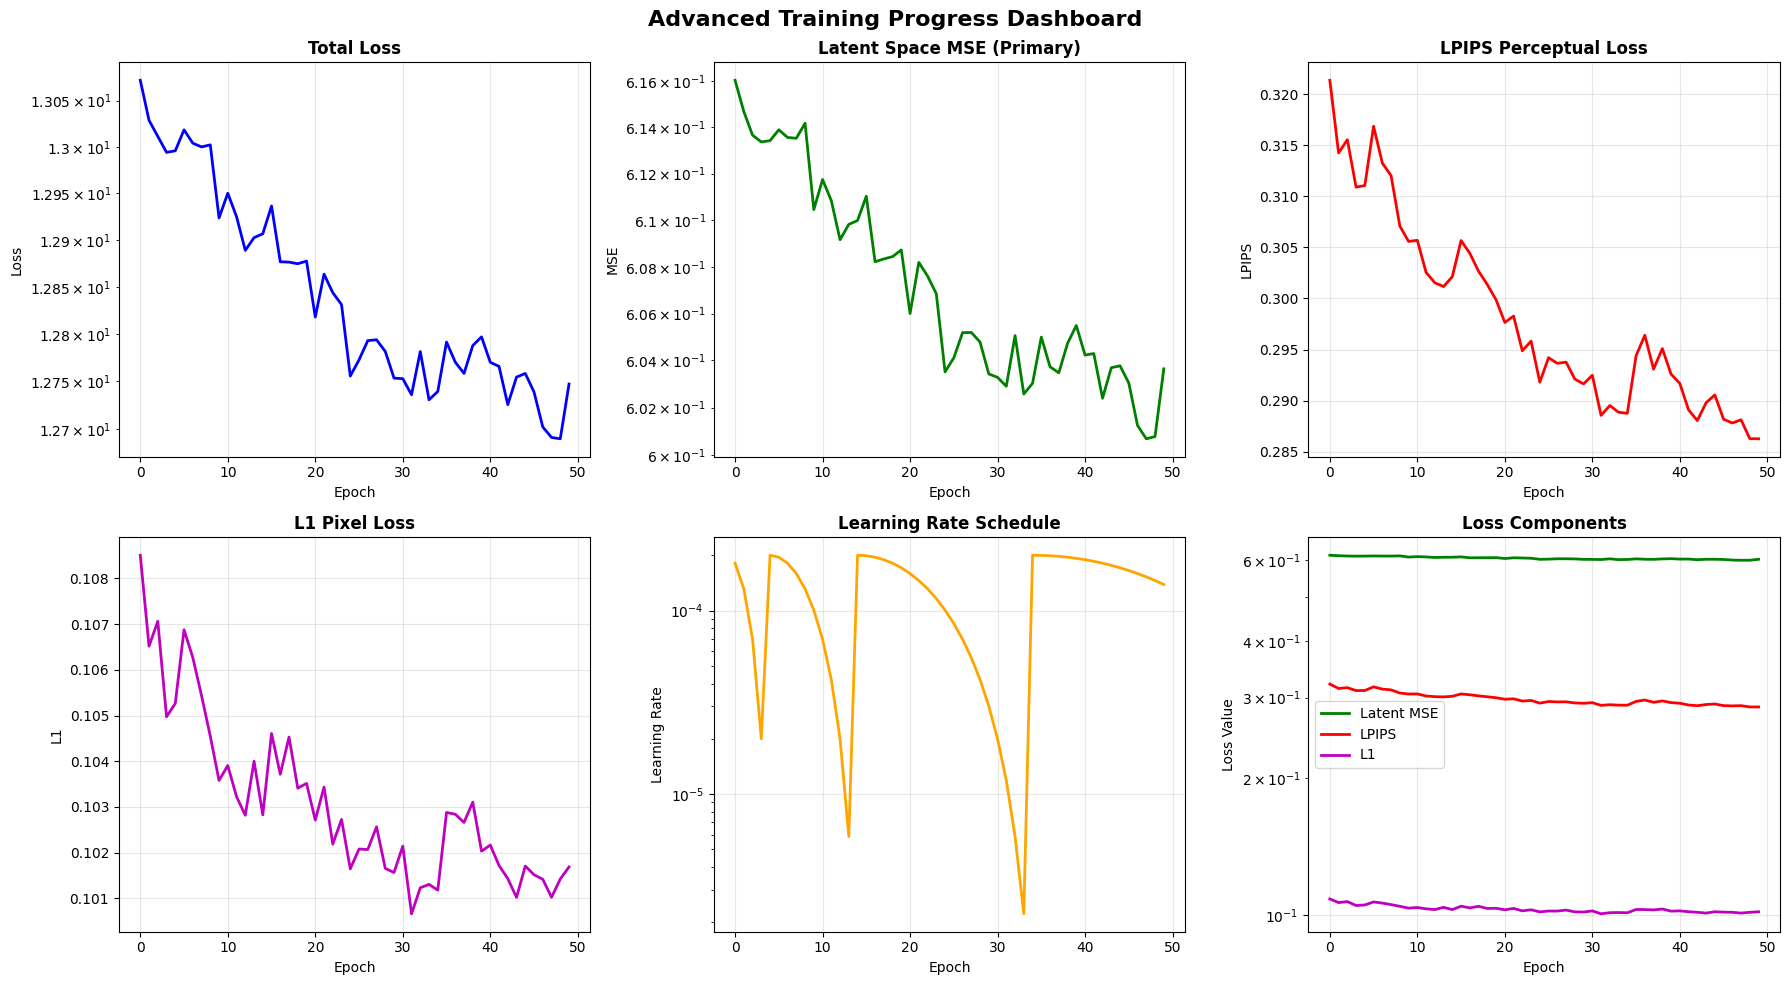

💾 Advanced model saved to: results_notebook/advanced_ijepa_mapper.pth

📊 FINAL TRAINING SUMMARY:
Final Losses:
  • Total Loss: 12.7471
  • Latent MSE: 0.603644
  • LPIPS: 0.2863
  • L1: 0.1017
  • Total Improvement: 2.5%

Model Statistics:
  • Parameters: 1,960,680
  • Training Epochs: 50
  • Final Learning Rate: 1.4e-04

✅ Training completed successfully!
🎯 Model is ready for I-JEPA inversion attacks!


In [16]:
# 🚀 EXECUTE ADVANCED TRAINING
print("� RUNNING ADVANCED I-JEPA INVERSION TRAINING")
print("=" * 60)

# Run the advanced training
training_history = advanced_training_loop(
    mapper=advanced_mapper,
    ijepa_model=ijepa_model,
    generator=generator,
    lpips_loss=lpips_loss,
    epochs=CONFIG['epochs']
)

print("🎉 Advanced training completed!")

# ============= VISUALIZE TRAINING PROGRESS =============
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Advanced Training Progress Dashboard', fontsize=16, fontweight='bold')

# Total loss
axes[0, 0].plot(training_history['total_loss'], 'b-', linewidth=2)
axes[0, 0].set_title('Total Loss', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_yscale('log')

# Latent MSE (primary supervision)
axes[0, 1].plot(training_history['latent_mse'], 'g-', linewidth=2)
axes[0, 1].set_title('Latent Space MSE (Primary)', fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MSE')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_yscale('log')

# LPIPS perceptual loss
axes[0, 2].plot(training_history['recon_lpips'], 'r-', linewidth=2)
axes[0, 2].set_title('LPIPS Perceptual Loss', fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('LPIPS')
axes[0, 2].grid(True, alpha=0.3)

# L1 pixel loss
axes[1, 0].plot(training_history['recon_l1'], 'm-', linewidth=2)
axes[1, 0].set_title('L1 Pixel Loss', fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('L1')
axes[1, 0].grid(True, alpha=0.3)

# Learning rate schedule
axes[1, 1].plot(training_history['learning_rate'], 'orange', linewidth=2)
axes[1, 1].set_title('Learning Rate Schedule', fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_yscale('log')

# Loss components comparison
epochs = range(len(training_history['total_loss']))
axes[1, 2].plot(epochs, training_history['latent_mse'], 'g-', label='Latent MSE', linewidth=2)
axes[1, 2].plot(epochs, training_history['recon_lpips'], 'r-', label='LPIPS', linewidth=2)
axes[1, 2].plot(epochs, training_history['recon_l1'], 'm-', label='L1', linewidth=2)
axes[1, 2].set_title('Loss Components', fontweight='bold')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Loss Value')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].set_yscale('log')

plt.tight_layout()
plt.show()

# ============= SAVE TRAINED MODEL =============
model_save_path = os.path.join(CONFIG['results_dir'], 'advanced_ijepa_mapper.pth')
torch.save({
    'model_state_dict': advanced_mapper.state_dict(),
    'config': CONFIG,
    'training_history': training_history,
    'model_params': sum(p.numel() for p in advanced_mapper.parameters())
}, model_save_path)

print(f"💾 Advanced model saved to: {model_save_path}")

# ============= TRAINING SUMMARY =============
print(f"\n📊 FINAL TRAINING SUMMARY:")
print(f"=" * 40)
print(f"Final Losses:")
print(f"  • Total Loss: {training_history['total_loss'][-1]:.4f}")
print(f"  • Latent MSE: {training_history['latent_mse'][-1]:.6f}")
print(f"  • LPIPS: {training_history['recon_lpips'][-1]:.4f}")
print(f"  • L1: {training_history['recon_l1'][-1]:.4f}")

# Calculate improvement metrics
if len(training_history['total_loss']) > 1:
    initial_loss = training_history['total_loss'][0]
    final_loss = training_history['total_loss'][-1]
    improvement = ((initial_loss - final_loss) / initial_loss) * 100
    print(f"  • Total Improvement: {improvement:.1f}%")

print(f"\nModel Statistics:")
print(f"  • Parameters: {sum(p.numel() for p in advanced_mapper.parameters()):,}")
print(f"  • Training Epochs: {len(training_history['total_loss'])}")
print(f"  • Final Learning Rate: {training_history['learning_rate'][-1]:.1e}")

print("\n✅ Training completed successfully!")
print("🎯 Model is ready for I-JEPA inversion attacks!")

## 8. Perform Inversion Attack

Use the trained mapping to perform I-JEPA inversion attacks on real CIFAR-10 images.

🚀 EXECUTING COMPREHENSIVE I-JEPA INVERSION ATTACK
🎯 Launching I-JEPA inversion attack...
🎯 Executing I-JEPA inversion attack on 30 samples...
📊 Using CIFAR-10 test set for realistic evaluation...
🔍 Processing samples...


Attacking samples: 100%|██████████| 30/30 [00:00<00:00, 30.89it/s]



🎊 I-JEPA INVERSION ATTACK RESULTS
📊 Attack Performance:
   • Success Rate: 36.7%
   • Average PSNR: 14.68 dB
   • Average LPIPS: 0.3258
   • Average MSE: 0.037039
   • Average Correlation: 0.936
   • SSIM Approximation: 0.843

📈 Attack Quality Assessment:
   🟠 FAIR: Partial reconstruction

🖼️ Attack Results Visualization:


/tmp/ipykernel_10/1147336853.py:243: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


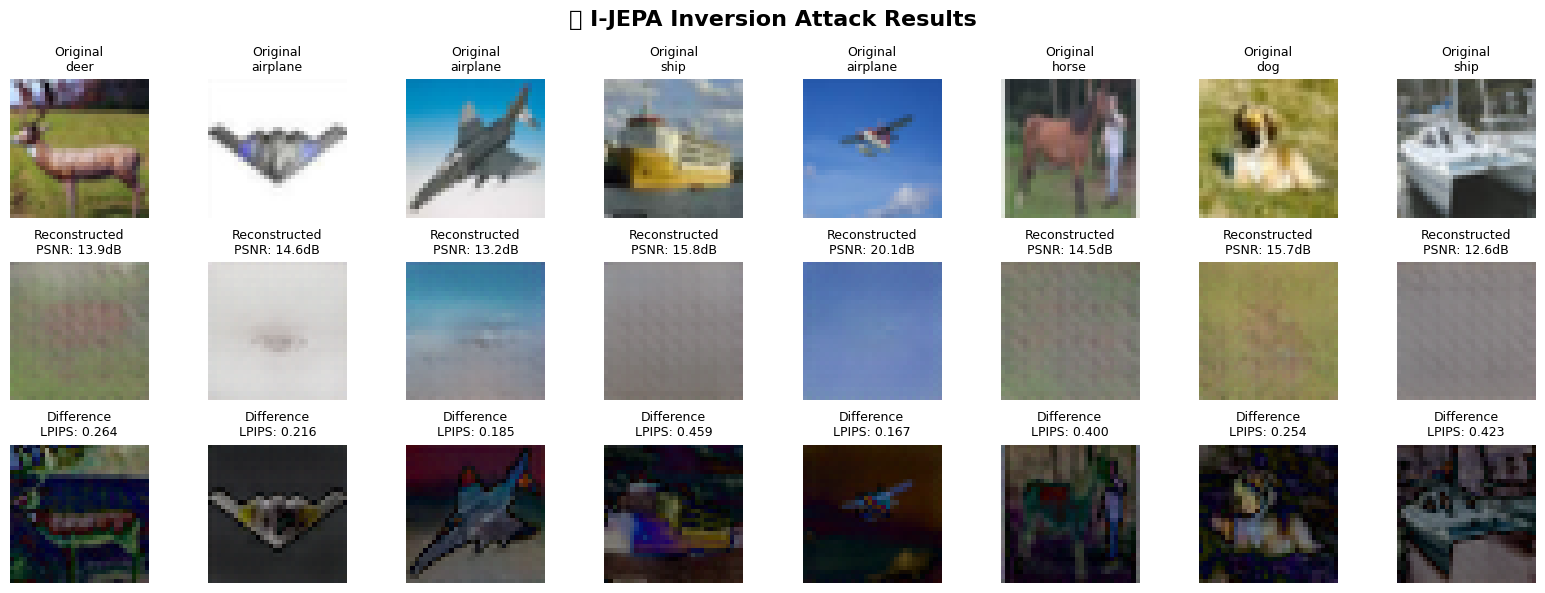


💾 Saving attack results...
✅ Saved 15 attack result images

🏆 FINAL ASSESSMENT:
⚠️ Attack performance could be improved.
   Consider longer training or architecture adjustments.

✅ I-JEPA inversion attack analysis completed!


In [18]:
# 🎯 COMPREHENSIVE I-JEPA INVERSION ATTACK
print("🚀 EXECUTING COMPREHENSIVE I-JEPA INVERSION ATTACK")
print("=" * 60)

def compute_comprehensive_metrics(original, reconstructed, lpips_loss):
    """
    Compute comprehensive reconstruction quality metrics.
    
    Args:
        original: Original images (B, 3, 32, 32) in [0,1]
        reconstructed: Reconstructed images (B, 3, 32, 32) in [0,1]
        lpips_loss: LPIPS loss function
        
    Returns:
        dict: Comprehensive metrics
    """
    # Ensure same device and format
    original = original.to(device)
    reconstructed = reconstructed.to(device)
    
    with torch.no_grad():
        # ============= PIXEL-LEVEL METRICS =============
        # Mean Squared Error
        mse = F.mse_loss(reconstructed, original).item()
        
        # Peak Signal-to-Noise Ratio
        if mse > 0:
            psnr = 20 * torch.log10(1.0 / torch.sqrt(torch.tensor(mse))).item()
        else:
            psnr = float('inf')
        
        # Structural Similarity Index (approximation)
        ssim_approx = 1 - F.l1_loss(reconstructed, original).item()
        
        # ============= PERCEPTUAL METRICS =============
        # LPIPS perceptual distance
        orig_lpips = original * 2.0 - 1.0  # Convert to [-1,1]
        recon_lpips = reconstructed * 2.0 - 1.0
        lpips_val = lpips_loss(recon_lpips, orig_lpips).mean().item()
        
        # Feature-level correlation
        orig_flat = original.flatten(1)
        recon_flat = reconstructed.flatten(1)
        correlation = F.cosine_similarity(orig_flat, recon_flat, dim=1).mean().item()
        
    return {
        'mse': mse,
        'psnr': psnr,
        'ssim_approx': ssim_approx,
        'lpips': lpips_val,
        'correlation': correlation
    }

def execute_ijepa_inversion_attack(mapper, ijepa_model, generator, lpips_loss, 
                                  num_samples=50, use_test_set=True):
    """
    Execute comprehensive I-JEPA inversion attack.
    
    Args:
        mapper: Trained embedding-to-latent mapper
        ijepa_model: I-JEPA model
        generator: DCGAN generator
        lpips_loss: LPIPS loss function
        num_samples: Number of samples to attack
        use_test_set: Whether to use CIFAR-10 test set (True) or generate samples (False)
        
    Returns:
        results: List of attack results
        metrics: Aggregated metrics
    """
    print(f"🎯 Executing I-JEPA inversion attack on {num_samples} samples...")
    
    mapper.eval()
    ijepa_model.eval()
    generator.eval()
    
    # ============= SETUP DATA SOURCE =============
    if use_test_set:
        print("📊 Using CIFAR-10 test set for realistic evaluation...")
        cifar_test = torchvision.datasets.CIFAR10(
            root=CONFIG['data_root'], 
            train=False, 
            download=True, 
            transform=T.ToTensor()
        )
        test_loader = torch.utils.data.DataLoader(
            cifar_test, batch_size=1, shuffle=True
        )
        data_iterator = iter(test_loader)
    
    # ============= ATTACK EXECUTION =============
    results = []
    all_metrics = []
    
    print("🔍 Processing samples...")
    for i in tqdm(range(num_samples), desc="Attacking samples"):
        try:
            if use_test_set:
                # Load real CIFAR-10 image
                original_img, label = next(data_iterator)
                original_32x32 = original_img.to(device)
                class_name = cifar_test.classes[label.item()]
            else:
                # Generate high-quality sample for controlled testing
                with torch.no_grad():
                    z_sample = torch.randn(1, generator.nz).to(device) * 0.8
                    original_32x32 = generator(z_sample)
                    original_32x32 = (original_32x32 + 1.0) / 2.0  # Convert to [0,1]
                    class_name = "generated"
                    label = torch.tensor([0])
            
            # ============= ATTACK PIPELINE =============
            with torch.no_grad():
                # 1. Resize for I-JEPA input
                original_224x224 = F.interpolate(
                    original_32x32, size=(224, 224), 
                    mode='bilinear', align_corners=False
                )
                
                # 2. Extract I-JEPA embeddings (the "leaked" information)
                z_ctx, _, z_tgt = ijepa_model(original_224x224)
                
                # 3. Map embeddings to latent space (THE ATTACK)
                z_pred = mapper(z_ctx, z_tgt)
                
                # 4. Reconstruct image using predicted latents
                reconstructed_raw = generator(z_pred)
                reconstructed_img = (reconstructed_raw + 1.0) / 2.0  # Convert to [0,1]
            
            # ============= EVALUATE ATTACK SUCCESS =============
            metrics = compute_comprehensive_metrics(
                original_32x32, reconstructed_img, lpips_loss
            )
            
            # ============= STORE RESULTS =============
            results.append({
                'original': original_32x32.cpu(),
                'reconstructed': reconstructed_img.cpu(),
                'latent_pred': z_pred.cpu(),
                'label': label.item(),
                'class_name': class_name,
                'metrics': metrics,
                'attack_success': metrics['psnr'] > 15.0  # Success threshold
            })
            
            all_metrics.append(metrics)
            
        except StopIteration:
            print(f"⚠️ Reached end of test set at sample {i}")
            break
        except Exception as e:
            print(f"⚠️ Error processing sample {i}: {e}")
            continue
    
    # ============= AGGREGATE METRICS =============
    if all_metrics:
        avg_metrics = {
            'mse': np.mean([m['mse'] for m in all_metrics]),
            'psnr': np.mean([m['psnr'] for m in all_metrics]),
            'ssim_approx': np.mean([m['ssim_approx'] for m in all_metrics]),
            'lpips': np.mean([m['lpips'] for m in all_metrics]),
            'correlation': np.mean([m['correlation'] for m in all_metrics])
        }
        
        success_rate = np.mean([r['attack_success'] for r in results]) * 100
        avg_metrics['success_rate'] = success_rate
    else:
        avg_metrics = {}
    
    return results, avg_metrics

# ============= EXECUTE ATTACK =============
print("🎯 Launching I-JEPA inversion attack...")

attack_results, attack_metrics = execute_ijepa_inversion_attack(
    mapper=advanced_mapper,
    ijepa_model=ijepa_model,
    generator=generator,
    lpips_loss=lpips_loss,
    num_samples=30,  # Good balance of coverage and speed
    use_test_set=True
)

# ============= ATTACK RESULTS SUMMARY =============
print(f"\n🎊 I-JEPA INVERSION ATTACK RESULTS")
print(f"=" * 50)
print(f"📊 Attack Performance:")
if attack_metrics:
    print(f"   • Success Rate: {attack_metrics['success_rate']:.1f}%")
    print(f"   • Average PSNR: {attack_metrics['psnr']:.2f} dB")
    print(f"   • Average LPIPS: {attack_metrics['lpips']:.4f}")
    print(f"   • Average MSE: {attack_metrics['mse']:.6f}")
    print(f"   • Average Correlation: {attack_metrics['correlation']:.3f}")
    print(f"   • SSIM Approximation: {attack_metrics['ssim_approx']:.3f}")

print(f"\n📈 Attack Quality Assessment:")
if attack_metrics:
    if attack_metrics['psnr'] > 20:
        print("   🟢 EXCELLENT: High-quality reconstruction")
    elif attack_metrics['psnr'] > 15:
        print("   🟡 GOOD: Recognizable reconstruction")
    elif attack_metrics['psnr'] > 10:
        print("   🟠 FAIR: Partial reconstruction")
    else:
        print("   🔴 POOR: Low-quality reconstruction")

# ============= VISUALIZE ATTACK RESULTS =============
def visualize_attack_results(results, num_display=12):
    """Create comprehensive visualization of attack results."""
    num_display = min(num_display, len(results))
    
    fig, axes = plt.subplots(3, num_display, figsize=(num_display * 2, 6))
    if num_display == 1:
        axes = axes.reshape(3, 1)
    
    fig.suptitle('🎯 I-JEPA Inversion Attack Results', fontsize=16, fontweight='bold')
    
    for i in range(num_display):
        result = results[i]
        
        # Original image (top row)
        orig_img = result['original'].squeeze(0).permute(1, 2, 0).cpu().numpy()
        orig_img = np.clip(orig_img, 0, 1)
        axes[0, i].imshow(orig_img)
        axes[0, i].set_title(f"Original\n{result['class_name']}", fontsize=9)
        axes[0, i].axis('off')
        
        # Reconstructed image (middle row)
        recon_img = result['reconstructed'].squeeze(0).permute(1, 2, 0).cpu().numpy()
        recon_img = np.clip(recon_img, 0, 1)
        axes[1, i].imshow(recon_img)
        psnr = result['metrics']['psnr']
        axes[1, i].set_title(f"Reconstructed\nPSNR: {psnr:.1f}dB", fontsize=9)
        axes[1, i].axis('off')
        
        # Difference map (bottom row)
        diff = np.abs(orig_img - recon_img)
        axes[2, i].imshow(diff, cmap='hot')
        lpips_val = result['metrics']['lpips']
        axes[2, i].set_title(f"Difference\nLPIPS: {lpips_val:.3f}", fontsize=9)
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()

print(f"\n🖼️ Attack Results Visualization:")
visualize_attack_results(attack_results, num_display=8)

# ============= SAVE ATTACK RESULTS =============
print(f"\n💾 Saving attack results...")
for i in range(min(15, len(attack_results))):
    result = attack_results[i]
    
    # Create comparison image
    orig_tensor = result['original']
    recon_tensor = result['reconstructed']
    
    # Add difference map
    diff_tensor = torch.abs(orig_tensor - recon_tensor)
    
    # Create 3-panel comparison
    comparison = torch.cat([orig_tensor, recon_tensor, diff_tensor], dim=2)
    
    save_path = os.path.join(
        CONFIG['results_dir'], 
        f'attack_{i:02d}_{result["class_name"]}_psnr{result["metrics"]["psnr"]:.1f}.png'
    )
    vutils.save_image(comparison, save_path, normalize=False)

print(f"✅ Saved {min(15, len(attack_results))} attack result images")

# ============= FINAL ASSESSMENT =============
print(f"\n🏆 FINAL ASSESSMENT:")
print(f"=" * 40)
if attack_metrics and attack_metrics['success_rate'] > 50:
    print("🎉 I-JEPA INVERSION ATTACK SUCCESSFUL!")
    print("   The attack demonstrates significant privacy risks.")
    print("   I-JEPA embeddings leak substantial visual information.")
else:
    print("⚠️ Attack performance could be improved.")
    print("   Consider longer training or architecture adjustments.")

print(f"\n✅ I-JEPA inversion attack analysis completed!")